# PANDA Approach #1 - Pseudo-Segmentation

## Motivation

The task is at its core a segmentation task - ideally we want to classify every region of tissue and then compare the total areas of each Gleason grade present and use that to reach an overall score. The problem with using a full segmentation approach is that it seems very unlikely that the labels, which are noisy in the case of Radboud and not granular in the case of Karolinska, are not accurate enough to go with proper segmentation. However, I believe that it is worth looking into segmentation on a larger scale via regions of the images. If we can seperate the image into many small tiles and then accurately label the tiles we should be able to achieve the same idea as segmentation but without the requirement of extremely high precision in the masks. The tiling process will also aid in eliminating the large amounts of white space in the whole slide images and only focusing on the actual tissue regions. This can be achieved by proceeding with tiling and then filtering the tiles based on mean pixel values and/or tiling the image masks as well and focusing on the tiles with the highest mask scores.

Considerations:
* What is the appropriate tile size?
* What resolution level should the tiling and classification be done at?
* Tile selection method - pixel sorting vs mask sorting?
* How many tiles to keep per image?
* How can we mitigate randomness in how cleanly tiles seperate gland features?
* Since the Radboud labeling method is more conducive to this approach will a model trained on just Radboud generalize to all data? If not can we somehow better align the Karolinska data so that a Radboud trained model will perform well?

## Workspace Initialization and Data Setup

In [1]:
# General packages
import os
import pandas as pd
import numpy as np
import zipfile
import pickle
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm.notebook import tqdm
from shutil import copyfile
copyfile(src = "../input/edahelperfuncs/eda_helper_funcs.py", dst = "../working/eda_helper_funcs.py")
copyfile(src = "../input/tiling-ex/dual_grid_demo.JPG", dst = "../working/dual_grid_demo.JPG")
from eda_helper_funcs import *
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay

# Image processing packages
from fastai.vision import *
import skimage.io
from PIL import Image
import openslide
from openslide import deepzoom
import cv2
import plotly.graph_objs as go

In [2]:
# Only look at images that we have masks for and match up the image and mask 
# lists so that they can be indexed in matching pairs
temp_list = sorted(os.listdir('../input/prostate-cancer-grade-assessment/train_label_masks'))
ims = []
masks = []
ids = []
for n in temp_list:
#     if n[-4:] == 'tiff' and 'mask' in n:
    ims.append(n[:-10]+'.tiff')
    masks.append(n[:-5]+'.tiff')
    ids.append(n[:-10])
print('Imgs length: ',len(ims))
print('Masks length: ',len(masks))
print('IDs length :', len(ids))
# Double check matching length
print(len(ims) == len(masks) and len(masks) == len(ids))

Imgs length:  10516
Masks length:  10516
IDs length : 10516
True


In [3]:
train_df = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv').set_index('image_id')
train_df = train_df.loc[train_df.index.isin(ids)]
print('Training dataframe shape: ', train_df.shape)
train_df.head(10)

Training dataframe shape:  (10516, 3)


data_provider  isup_grade gleason_score
image_id                                                                
0005f7aaab2800f6170c399693a96917    karolinska           0           0+0
000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0
0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4
001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4           4+4
001d865e65ef5d2579c190a0e0350d8f    karolinska           0           0+0
002a4db09dad406c85505a00fb6f6144    karolinska           0           0+0
003046e27c8ead3e3db155780dc5498e    karolinska           1           3+3
0032bfa835ce0f43a92ae0bbab6871cb    karolinska           1           3+3
003a91841da04a5a31f808fb5c21538a    karolinska           1           3+3
003d4dd6bd61221ebc0bfb9350db333f    karolinska           1           3+3

Test image file:  ../input/prostate-cancer-grade-assessment/train_images/0018ae58b01bdadc8e347995b69f99aa.tiff

Full-size image dimensions: 		 (5888, 25344) 
One-fourth size image dimensions: 	 (1472, 6336) 
One-sixteenth size image dimensions: 	 (368, 1584) 

Image preview:


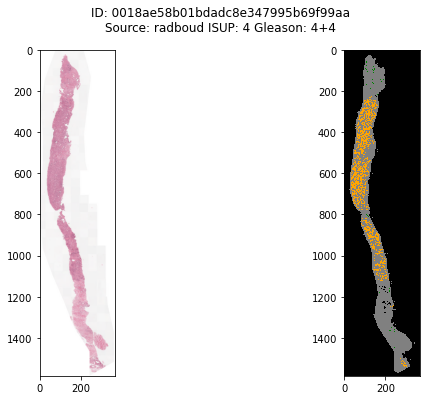

In [4]:
BASE_PATH = '../input/prostate-cancer-grade-assessment'
data_dir = f'{BASE_PATH}/train_images'
mask_dir = f'{BASE_PATH}/train_label_masks'

img_mask_check(train_df.index[2],data_dir,mask_dir,train_df)

In [5]:
# Demonstrating frequency counting of various mask labels in a sample image, which will be used for tile ground-truth labeling
mask_temp = open_slide_level(os.path.join(mask_dir,f'{train_df.index[2]}_mask.tiff'))
print('Mask label counts (held within the R-channel of the mask image file): ')
(unique, counts) = np.unique(mask_temp[:,:,0], return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

Mask label counts (held within the R-channel of the mask image file): 
[[      0 7358450]
 [      1 1526299]
 [      2   12627]
 [      4  429216]]


## Image Tiling and Visualization

In [6]:
def tile_gleason_grade(mask,sz,scoring_thresh):
    """"Provides a single gleason grade for a tile based on its mask
    Inputs:
        mask: np-array mask for the image tile (mask values in the R-channel of sz x sz x 3 array)
        sz: dimension (sz = h = w) for the mask
        scoring_thresh: the decimal percentage of area of the mask that must be present of the highest grade cancer that 
            the tile will be labeled as
    Output:
        Integer score (0-5) for the gleason grade for the given tile 
    """
    (unique, counts) = np.unique(mask[:,:,0], return_counts=True)
    frequencies = np.asarray((unique, counts)).T        
    frequencies = frequencies[frequencies[:,1] > int(sz**2 * scoring_thresh)]
    if len(frequencies[:,0]) < 1:
           return 0
    tile_gleason_label = frequencies[np.argmax(frequencies[:,0])][0]
    return tile_gleason_label

def tile_masksort_highres(image_id,lvl=1,sz=64,N=256):
    """ Produces a set of N tiles, each with sz x sz dimensions, from the image image_id
    Inputs:
        image_id: sample image ID from the dataset
        lvl: resolution level of the image at which the sorting and filtering is processed
        sz: size of tiles at the lvl resolution level, final tiles will be sz * 4^(lvl) (sz = 64, lvl = 1 yields 256x256
            full resolution tiles)
        N: the desired number of tiles

    Output:
        A list containing N elements. Each element is a dictionary that contains an image tile ('img'), its mask ('mask'),
        its place in the list according to the sorting and filtering that has been used ('idx'), its original index in the image
        which can be translated to its original coordinates in the image ('orig_idx')
    """  
    img = open_slide_level(os.path.join(data_dir,f'{image_id}.tiff'), lvl)
    mask = open_slide_level(os.path.join(mask_dir,f'{image_id}_mask.tiff'), lvl)
    result = []
    
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                constant_values=255)
    mask = np.pad(mask,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                constant_values=0)
    shape = img.shape

    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    mask = mask.reshape(mask.shape[0]//sz,sz,mask.shape[1]//sz,sz,3)
    mask = mask.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)

    idxs = np.flip(np.argsort(mask.reshape(mask.shape[0],-1).sum(-1))[-N:])
    mask = mask[idxs]
    full_img = openslide.open_slide(os.path.join(data_dir,f'{image_id}.tiff'))
    for i in range(len(idxs)):
        a = int((idxs[i] // (shape[1]/sz) *sz - pad0//2) * (4 **(lvl - 0)))
        b = int((idxs[i] %  (shape[1]/sz) *sz - pad1//2) * (4 **(lvl - 0)))
        temp_img = np.array(full_img.read_region((b,a),0,(sz*4,sz*4)))
        temp_img = rgba2rgb(temp_img)
        result.append({'img':temp_img, 'mask':mask[i], 'idx':i, 'orig_idx':idxs[i], 
                       'gleason_grade':tile_gleason_grade(mask[i],sz,scoring_thresh=0.10)})
    return result

def display_tiles(tile_list, num_imgs, img_id, train_df = train_df):
    """ Displays a side-by-side comparison of image tiles and their corresponding masks with labels
    Inputs:
        tile_list: the output of a tiling function that contains tiles and masks
        num_imgs: the number of images desired to be output
        img_id: the image ID from which the tiles were created
        train_df: the dataframe containing all of the data about the dataset (image_ids, gleason scores, isup grades)

    Output:
        None
    """     
    
    f, ax = plt.subplots(num_imgs,2, figsize=(18,25))
    cmap = matplotlib.colors.ListedColormap(['white', 'gray', 'green', 'yellow', 'orange', 'red'])
    for i, tile in enumerate(tile_list):
        ax[i, 0].imshow(tile['img'])
        ax[i, 0].set_title(f"Index: {tile['idx']}, Pxl Mean: {np.mean(tile['img'])}")
        ax[i, 1].imshow(tile['mask'][:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
        (unique, counts) = np.unique(tile['mask'][:,:,0], return_counts=True)
        frequencies = np.asarray((unique, counts)).T 
        data_provider, isup_grade, gleason_score= train_df.loc[img_id]
        if data_provider == 'radboud':
            labels = {'0': 'background (non tissue) or unknown', 
                  '1': 'stroma (connective tissue, non-epithelium tissue)',
                  '2': 'healthy (benign) epithelium',
                  '3': 'cancerous epithelium (Gleason 3)',
                  '4': 'cancerous epithelium (Gleason 4)',
                  '5': 'cancerous epithelium (Gleason 5)'}
        else:
            labels = {'0': 'background (non tissue) or unknown', 
                  '1': 'benign tissue (stroma and epithelium combined)',
                  '2': 'cancerous tissue (stroma and epithelium combined)',}

        ax[i, 1].set_title(f"Label: {labels[str(tile['gleason_grade'])]} \nMask Mean: {tile['mask'][:,:,0].mean()}")
        
    plt.suptitle(f"ID: {img_id}\nSource: {data_provider}, ISUP: {isup_grade}, Gleason: {gleason_score}")
    plt.show() 

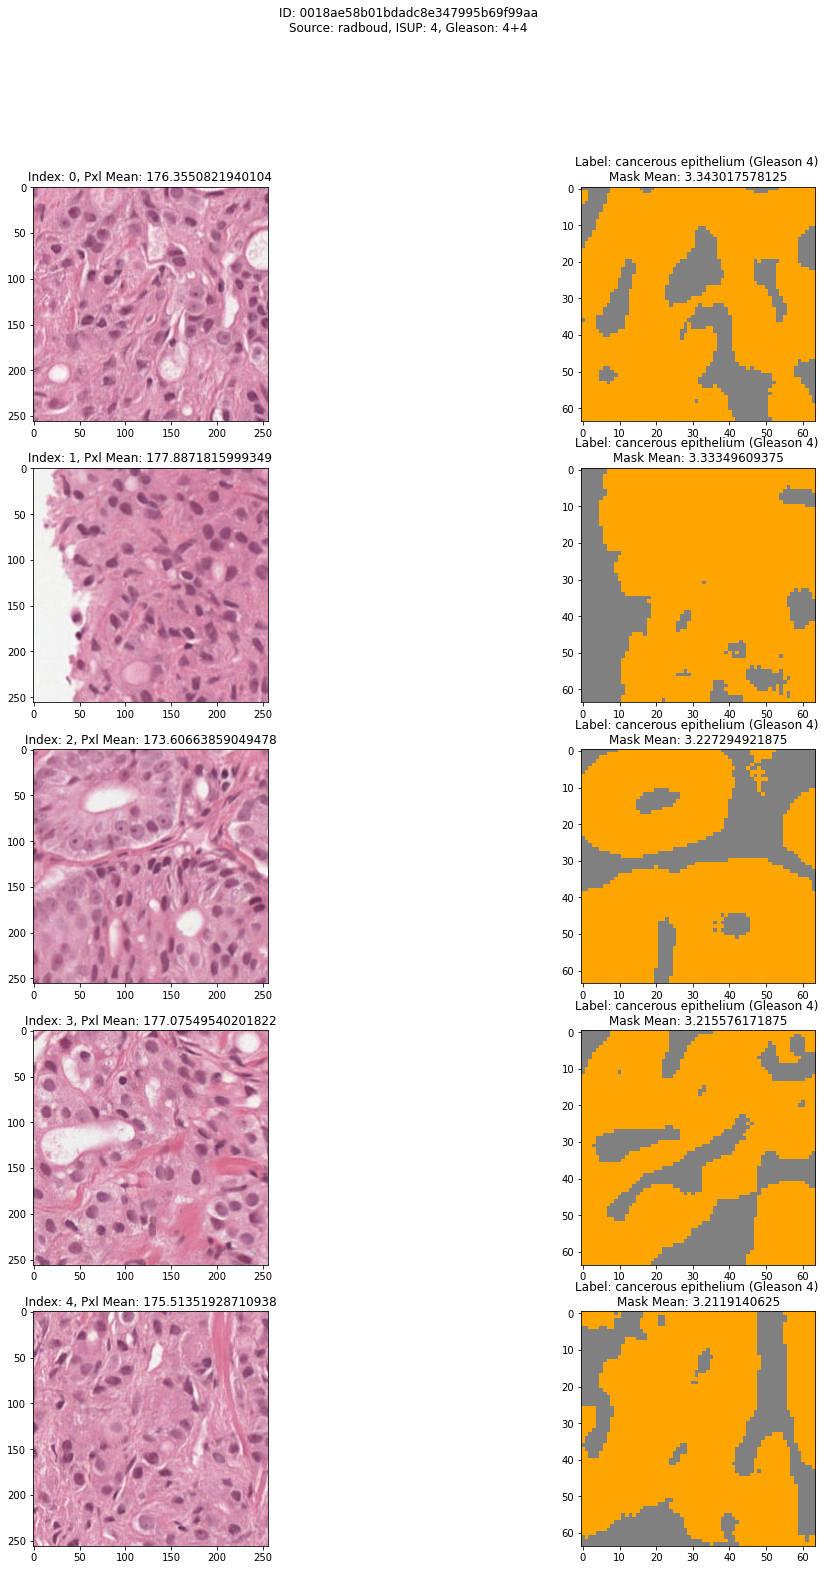

In [7]:
# Test tiling of an image and display the first 5 tiles as ranked by the highest mask values (focus on highest 
# cancer regions). Note that the scale of the actual images is 4x that of the masks because the mask analysis is done
# at a lower resolution level of the image so as to be computationally more efficient
tiles = tile_masksort_highres(train_df.index[2],1)
display_tiles(tiles[:5],5, train_df.index[2])

Above we can see that the mask sorting function is working properly and producing images in decreasing order of the most high-risk cancer present in the tile. We can also see that the features match up between the higher resolution image and its mask.

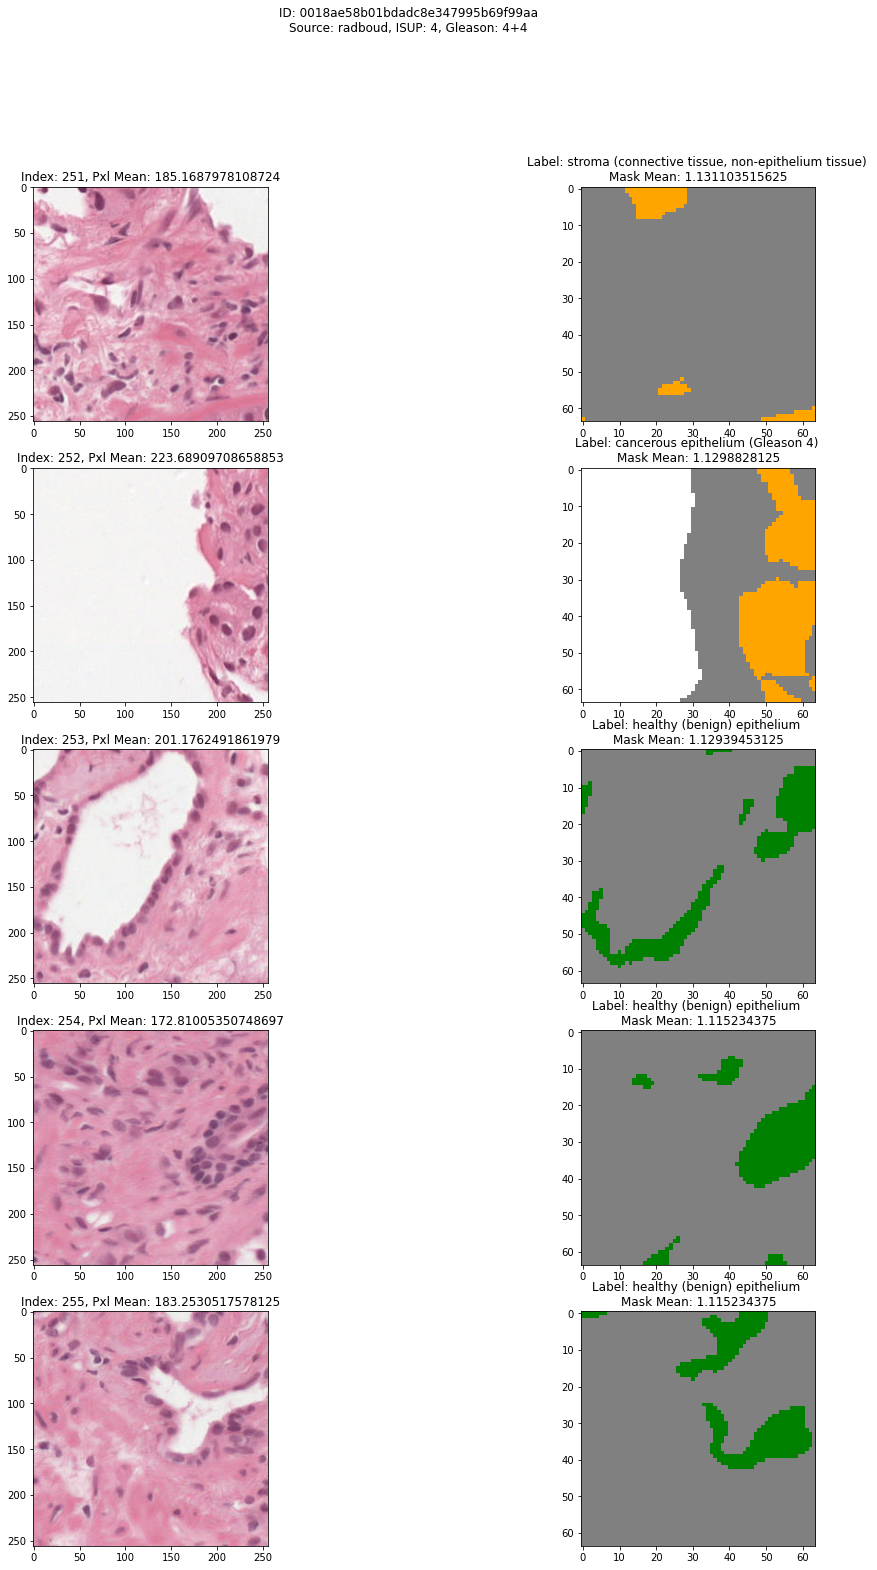

In [8]:
# Check the last 5 tiles in that set
display_tiles(tiles[-5:],5, train_df.index[2])

Looking at the last 5 images in the tile set helps to display the issues from our original set of concerns. In the top image it is not clear that the mask matches with the image - this is likely a result of where the tile division happened to fall resulting in the rest of the glands that are driving those labels being cut off. As a result we end up with a tile that is labeled as Gleason 4 (based on this function currently using a 10% area threshold for labeling) despite not showing clear features of grade 4 tissue. This could also potentially be attributed to the noise in the Radboud center's labeling algorithm extending slightly beyond the (cut off) regions that it had identified.

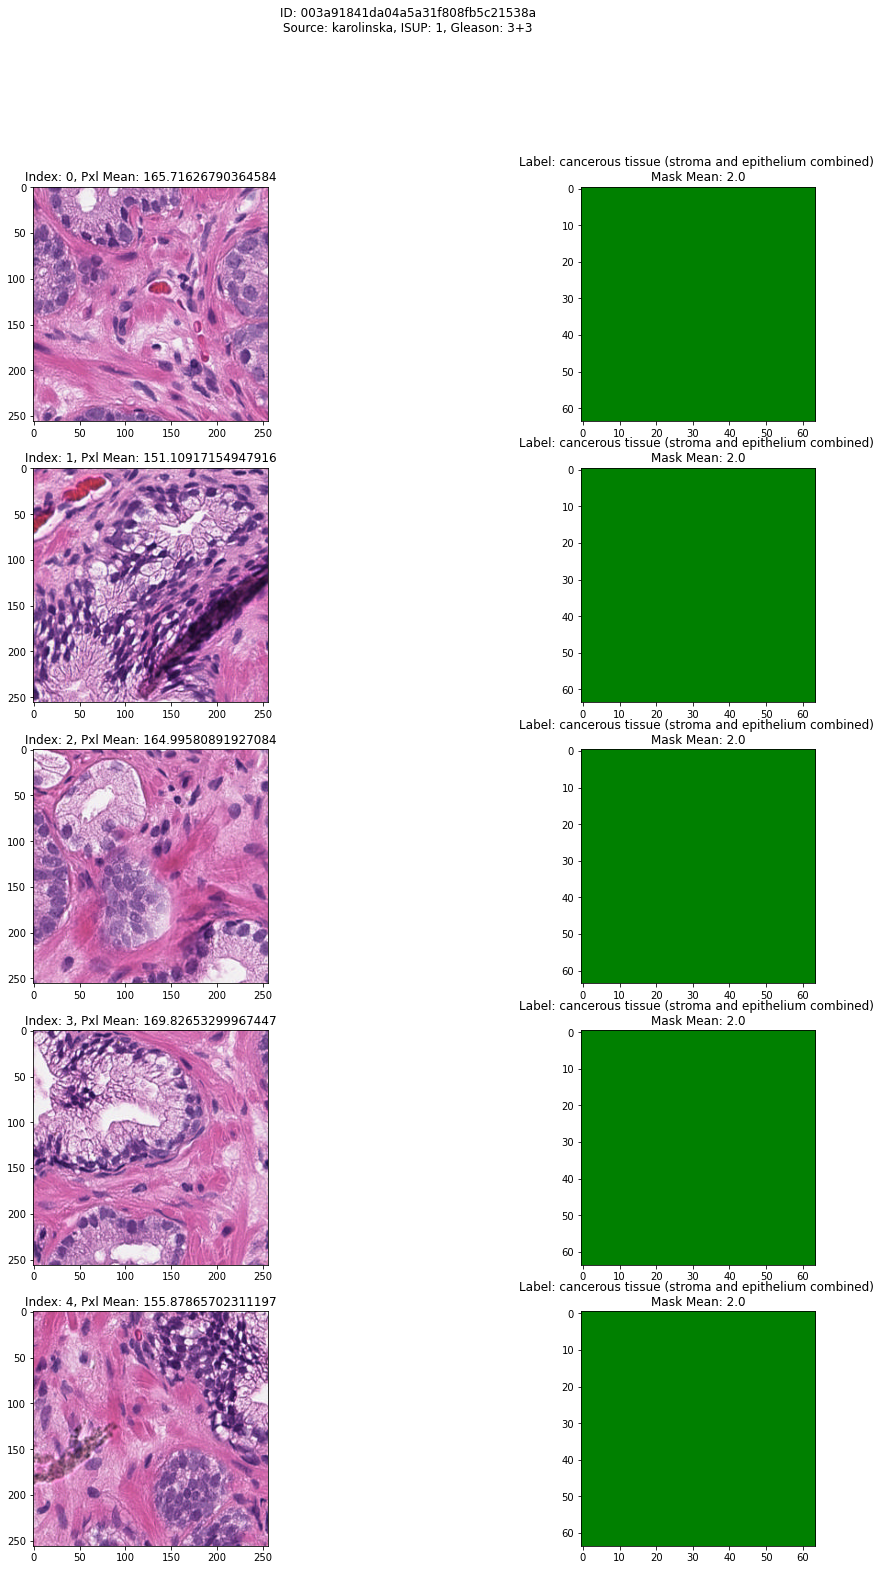

In [9]:
# Test this method on another image
tiles = tile_masksort_highres(train_df.index[8],1)
display_tiles(tiles[:5],5, train_df.index[8])

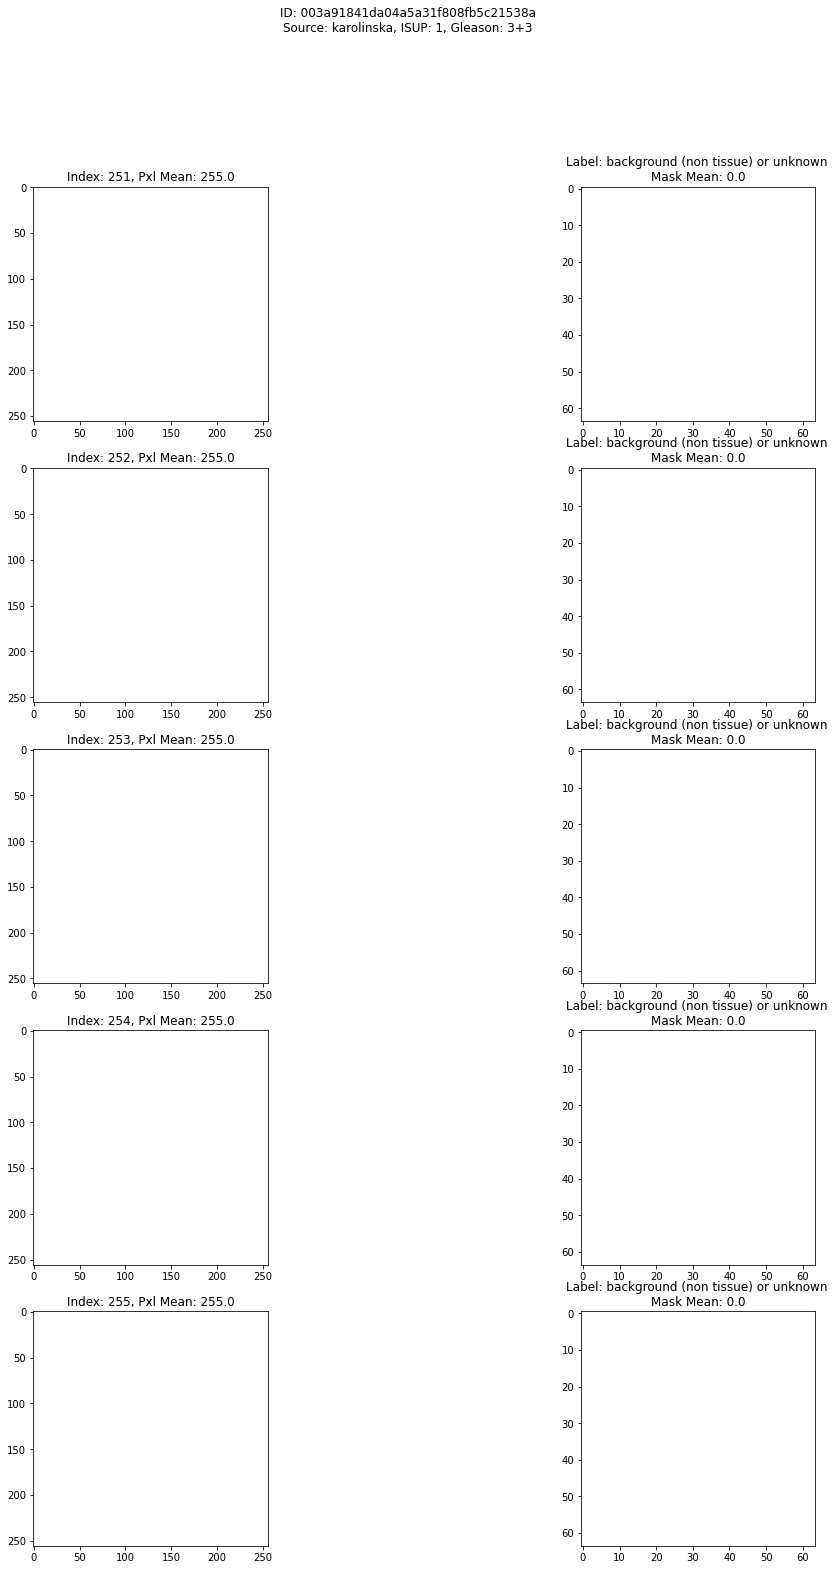

In [10]:
display_tiles(tiles[-5:],5, train_df.index[8])

Not surprisingly, using a constant number of tiles per image is a poor choice as it ends up discarding useful tiles or keeping blank tiles.


Fixing some of the issues that we discovered:
* Implement average mask grade and average pixel value thresholds to ensure that only valuable tiles are kept
* Now that there will not be blank tiles change N from a target number of tiles to N_max and increase the value so that we can keep a large number of relevant tiles if they exist
* Make the scoring threshold an argument to the function so that it can be easily varied as desired
* Make the final tile resolution level an argument of the function so that it too can be easily varied
* Implement a secondary grid to prevent data destruction due to location at original tile corners and edges

*Illustration of tiling location issue resolution:*
![image](dual_grid_demo.JPG)

In [11]:
def tile_fullfilter_variableres(image_id,tile_lvl=0,prep_lvl=1,sz=64,mask_thresh=1.05,pxl_thresh=220.0,
                                scoring_thresh=0.10,N_max=256,train_df=train_df):
    """ Produces a set of N tiles, each with sz x sz dimensions, from the image image_id
    Inputs:
        image_id: sample image ID from the dataset
        tile_lvl: resolution level of the image from which the tiles are taken
        prep_lvl: resolution level of the image at which the sorting and filtering is processed
        sz: size of tiles at prep_lvl level, final tiles will be sz * 4^(prep_lvl-tile_lvl) e.g. sz = 64, prep_lvl = 1, 
            tile_lvl = 0    yields 256x256 size final tiles
        mask_thresh: the average mask value required for a tile to be kept (greater values are kept)
        pxl_thresh: the average image pixel value required for a tile to be kept (smaller/darker values are kept to avoid whitespace)
        scoring_thresh: the decimal percentage of area of the mask that must be present of the highest grade cancer that 
            the tile will be labeled as
        N_max: the maximum number of tiles to be kept per image
        train_df: the dataframe containing all of the data about the dataset (image_ids, gleason scores, isup grades)

    Output:
        A list containing <N_max*2 elements. Each element is a dictionary that contains an image tile ('img'), its mask ('mask'),
        its place in the list according to the sorting and filtering that has been used ('idx'), its original index in the image
        which can be translated to its original coordinates in the image ('orig_idx')
    """  
    img = open_slide_level(os.path.join(data_dir,f'{image_id}.tiff'), prep_lvl)
    mask = open_slide_level(os.path.join(mask_dir,f'{image_id}_mask.tiff'), prep_lvl)
    result = []
    
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],constant_values=255)
    mask = np.pad(mask,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],constant_values=0)
    shape = img.shape
    
    img2 = img[int(sz/2):int(-sz/2),int(sz/2):int(-sz/2),:]
    mask2 = mask[int(sz/2):int(-sz/2),int(sz/2):int(-sz/2),:]
    shape2 = mask2.shape

    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    mask = mask.reshape(mask.shape[0]//sz,sz,mask.shape[1]//sz,sz,3)
    mask = mask.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    
    img2 = img2.reshape(img2.shape[0]//sz,sz,img2.shape[1]//sz,sz,3)
    img2 = img2.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    mask2 = mask2.reshape(mask2.shape[0]//sz,sz,mask2.shape[1]//sz,sz,3)
    mask2 = mask2.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)

    m_mean = mask[:,:,:,0].mean((1,2))
    i_mean = img.reshape(img.shape[0],-1).mean(-1)
    idxs = np.argsort(i_mean)
    idxs = idxs[((m_mean[idxs] > mask_thresh) & (i_mean[idxs] < pxl_thresh ))]
    if len(idxs) > N_max:
        idxs = idxs[:N_max]
    mask = mask[idxs]
    
    m_mean2 = mask2[:,:,:,0].mean((1,2))
    i_mean2 = img2.reshape(img2.shape[0],-1).mean(-1)
    idxs2 = np.argsort(i_mean2)
    idxs2 = idxs2[((m_mean2[idxs2] > mask_thresh) & (i_mean2[idxs2] < pxl_thresh ))]
    if len(idxs2) > N_max:
        idxs2 = idxs2[:N_max]
    mask2 = mask2[idxs2]
    
    
    full_img = openslide.open_slide(os.path.join(data_dir,f'{image_id}.tiff'))
    for i in range(len(idxs)):
        a = int((idxs[i] // (shape[1]/sz) *sz - pad0//2) * (4 **(prep_lvl - tile_lvl)))
        b = int((idxs[i] %  (shape[1]/sz) *sz - pad1//2) * (4 **(prep_lvl - tile_lvl)))
        temp_img = np.array(full_img.read_region((b,a),tile_lvl,(sz*4**(prep_lvl - tile_lvl),sz*4**(prep_lvl - tile_lvl))))
        temp_img = rgba2rgb(temp_img)
        result.append({'img':temp_img, 'mask':mask[i], 'idx':i, 'orig_idx':idxs[i], 
                       'gleason_grade':tile_gleason_grade(mask[i],sz,scoring_thresh)})
        
    for i in range(len(idxs2)):
        a = int(((idxs2[i] // (shape2[1]/sz) + 1/2 ) *sz - pad0//2) * (4 **(prep_lvl - tile_lvl)))
        b = int(((idxs2[i] %  (shape2[1]/sz) + 1/2 ) *sz - pad1//2) * (4 **(prep_lvl - tile_lvl)))
        temp_img = np.array(full_img.read_region((b,a),0,(sz*4**(prep_lvl - tile_lvl),sz*4**(prep_lvl - tile_lvl))))
        temp_img = rgba2rgb(temp_img)
        result.append({'img':temp_img, 'mask':mask2[i], 'idx':i, 'orig_idx':idxs2[i], 
                       'gleason_grade':tile_gleason_grade(mask2[i],sz,scoring_thresh)})
    return result

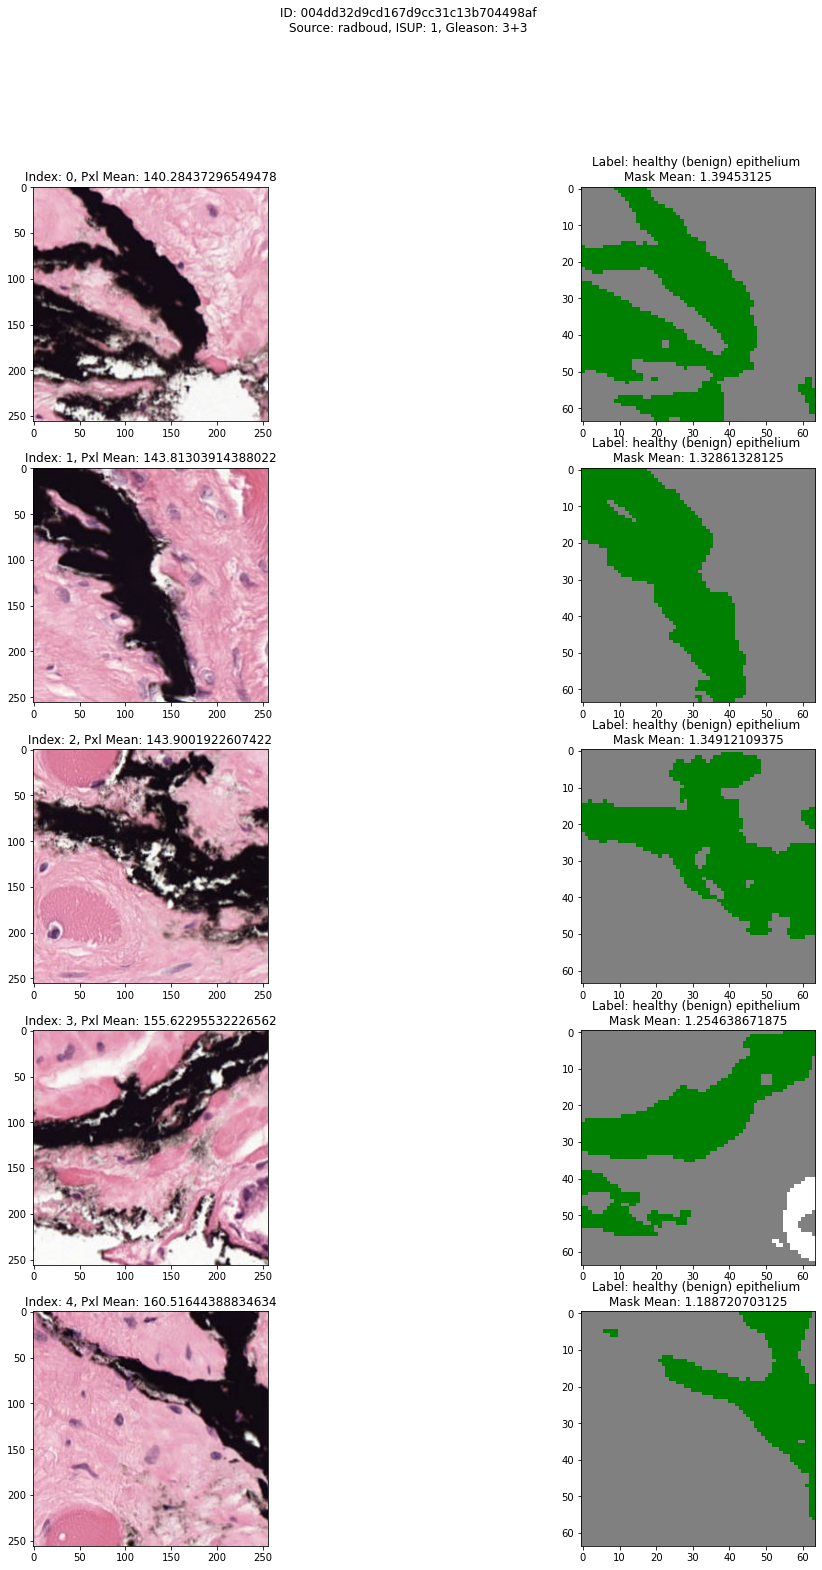

In [12]:
tiles = tile_fullfilter_variableres(train_df.index[12],tile_lvl=0,prep_lvl=1,sz=64,mask_thresh=1.05,pxl_thresh=220.0,
                                scoring_thresh=0.10,N_max=256,train_df=train_df)
display_tiles(tiles[:5],5, train_df.index[12])

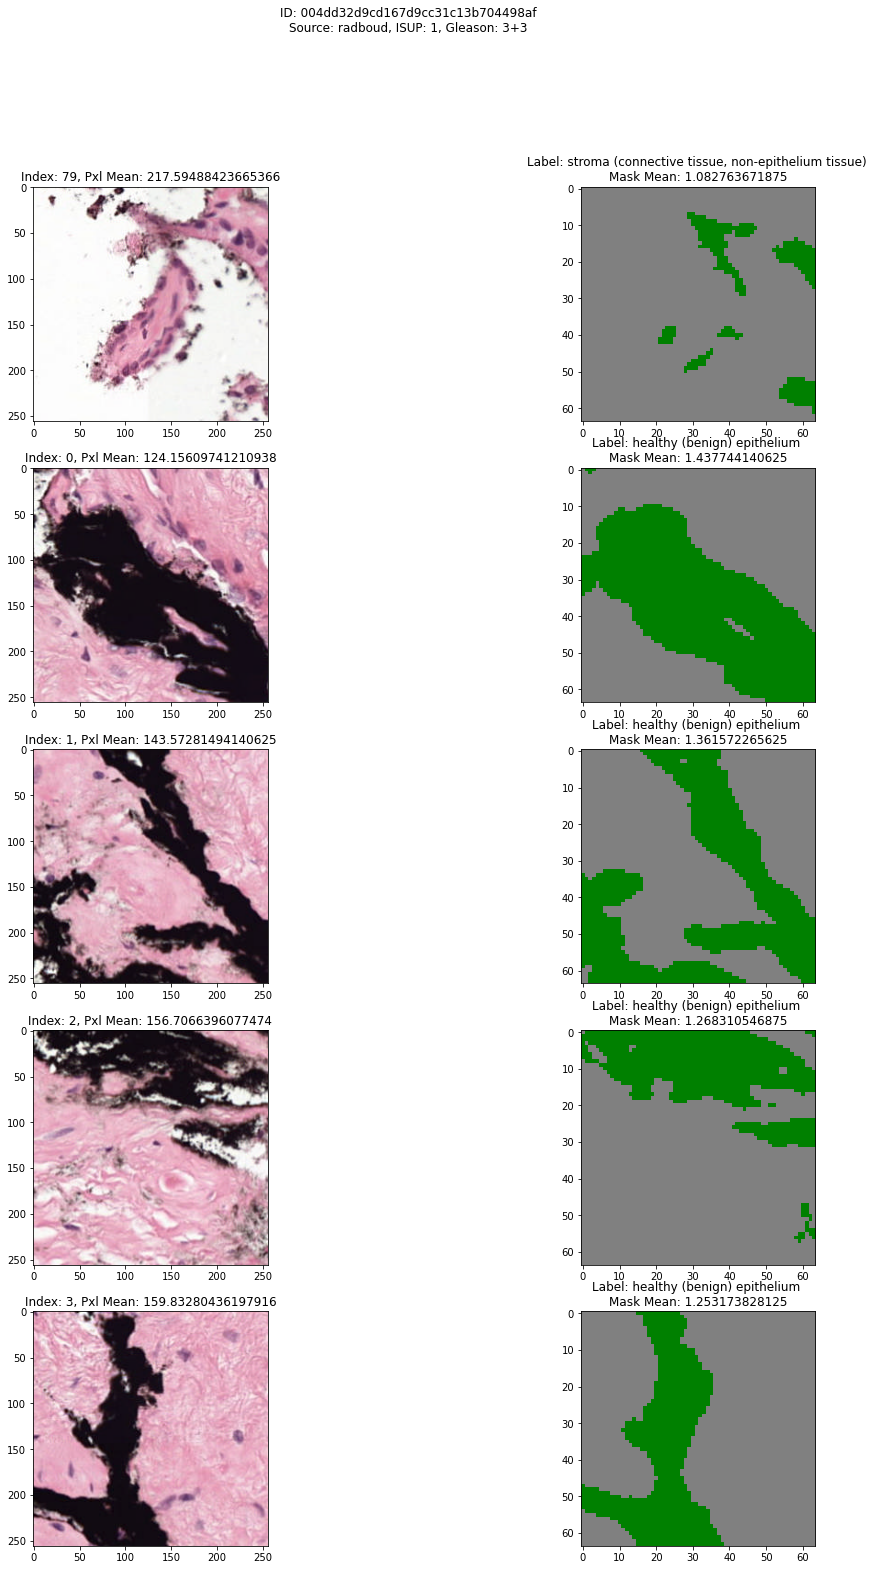

In [13]:
# check middle of set of tiles, where the index resets (image 2 below) indicates the beginning of tiles from the secondary grid
display_tiles(tiles[int(len(tiles)/2)-3:int(len(tiles)/2)+2],5, train_df.index[12])

Test image file:  ../input/prostate-cancer-grade-assessment/train_images/004dd32d9cd167d9cc31c13b704498af.tiff

Full-size image dimensions: 		 (8192, 22528) 
One-fourth size image dimensions: 	 (2048, 5632) 
One-sixteenth size image dimensions: 	 (512, 1408) 

Image preview:


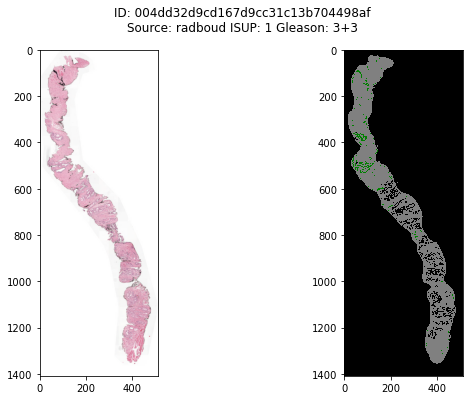

In [14]:
img_mask_check(train_df.index[12],data_dir,mask_dir,train_df)

In [15]:
# Demonstrating frequency counting of various mask labels in a sample image, which will be used for tile ground-truth labeling
mask_temp = open_slide_level(os.path.join(mask_dir,f'{train_df.index[12]}_mask.tiff'))
print('Mask label counts (held within the R-channel of the mask image file): ')
(unique, counts) = np.unique(mask_temp[:,:,0], return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

Mask label counts (held within the R-channel of the mask image file): 
[[      0 9576540]
 [      1 1875396]
 [      2   82400]]


In [16]:
tiles_df = pd.DataFrame(tiles)
tiles_df.gleason_grade.value_counts()

2    104
1     60
Name: gleason_grade, dtype: int64

The image above, sample 004dd32d9cd167d9cc31c13b704498af, exhibits alarming behavior for the pseudo-segmentation approach to this problem. Although the image is labeled as ISUP:1, Gleason:3+3, the mask for the image does not have any regions of cancer identified (mask value greater than or equal to 3) and the resulting tiles that we have created are not labeled as cancerous. Therefore even if we were able to develop a classification model that predicted the classification of each tile perfectly according to its ground-truth mask, we would identify this image incorrectly as ISUP:0 or non-cancerous.

In order to test whether this is an isolated issue or a large scale problem, we will do a test of the approach on a reasonably large set of images below. The test will simulate creating tiles for each image and using the ground-truth labels of the tiles (created from the corresponding masks) to predict an overall Gleason score and ISUP grade for the image as a whole. Those predicted scores will then be compared to the actual labels for the samples and performance scored using the same method as the competition (quadratic weighted kappa). This test will simulate the performance of a model that can classify tiles at perfect accuracy and provide an upper bound on the performance that we should expect to achieve using this strategy. Note this strategy as currently implemented is still focused solely on the data from the Radboud center because of the differences in masks between the two centers, if it shows promise then we will proceed with trying to bridge the gap between the data from the two centers such that the model will generalize to both.

In [17]:
def image_gleason_score(tile_gleason_grades,return_cts=False):
    """"Provides an overall gleason score for an image based on its tiles and their gleason grade labels
    Inputs:
        tile_gleason_grades: List containing the gleason grade labels for all of the tiles of the image
        return_cts: Boolean, whether to reuturn the total and individual tile counts
        
    Output:
        string score of the form: 'primary gleason grade + secondary gleason grade' e.g. '3+4'
        (optional) indiviual counts of each grade level and a total
    """
    a = np.array(tile_gleason_grades)
    (unique, counts) = np.unique(a, return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    # ignore background tiles if they exist (label = 0)
    frequencies = frequencies[frequencies[:,0]>0]
    tot = frequencies[:,1].sum()
    graded = frequencies[frequencies[:,0]>1][:,1].sum()
    cts = []
    for num in [1,2,3,4,5]:
        if num in frequencies[:,0]:
            cts.append(int(frequencies[frequencies[:,0]==num,1]))
        else:
            cts.append(0)
    
    # check if any cancerous gland type exceeds 5% of the area, if so proceed with cancerous grading, else return non-cancer
    if frequencies[((frequencies[:,0] >= 3) & (frequencies[:,1] > int(graded*.05)))].shape[0]>=1:
        frequencies = frequencies[((frequencies[:,0] >= 3) & (frequencies[:,1] > int(graded*.05)))]
        rank = np.argsort(frequencies[:,1])
        high = frequencies[np.argsort(frequencies[:,0])[-1],0]
        first = frequencies[rank[-1],0]
        if first != high:
            second = high
        elif len(rank) >1 and frequencies[rank[-2],1] > int(graded*.05):
            second = frequencies[rank[-2],0]
        else:            
            second = first
    else:
        first = 0;second = 0
    
    if not return_cts:
        return str(str(first)+'+'+str(second))
    else:
        return str(str(first)+'+'+str(second)), tot, cts   

# Dictionary for converting Gleason Scores to ISUP grades
gleason_to_isup = {
    '0+0':0,
    '3+3':1,'3+4':2,'3+5':4,
    '4+3':3,'4+4':4,'4+5':5,
    '5+3':4,'5+4':5,'5+5':5,    
  }

In [18]:
def tile_strategy_test(image_id,tile_lvl=0,prep_lvl=1,sz=64,mask_thresh=1.02,pxl_thresh=225.0,
                                scoring_thresh=0.10,N_max=256,train_df=train_df):
    """ Produces a list of the gleason grades that would be assigned to the set of tiles created for the given sample image
    Inputs:
        image_id: sample image ID from the dataset
        tile_lvl: resolution level of the image from which the tiles are taken
        prep_lvl: resolution level of the image at which the sorting and filtering is processed
        sz: size of tiles at prep_lvl level, final tiles will be sz * 4^(prep_lvl-tile_lvl) e.g. sz = 64, prep_lvl = 1, 
            tile_lvl = 0    yields 256x256 size final tiles
        mask_thresh: the average mask value required for a tile to be kept (greater values are kept)
        pxl_thresh: the average image pixel value required for a tile to be kept (smaller/darker values are kept to avoid 
            whitespace)
        scoring_thresh: the decimal percentage of area of the mask that must be present of the highest grade cancer that 
            the tile will be labeled as
        N_max: the maximum number of tiles to be kept per image
        train_df: the dataframe containing all of the data about the dataset (image_ids, gleason scores, isup grades)

    Output:
        A list containing <N_max*2 elements. Each element is an integer gleason grade for a tile that would be created from the 
        given sample image. 
    """  
    img = open_slide_level(os.path.join(data_dir,f'{image_id}.tiff'), prep_lvl)
    mask = open_slide_level(os.path.join(mask_dir,f'{image_id}_mask.tiff'), prep_lvl)
    result = []
    
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],constant_values=255)
    mask = np.pad(mask,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],constant_values=0)
    shape = img.shape
    
    img2 = img[int(sz/2):int(-sz/2),int(sz/2):int(-sz/2),:]
    mask2 = mask[int(sz/2):int(-sz/2),int(sz/2):int(-sz/2),:]
    shape2 = mask2.shape

    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    mask = mask.reshape(mask.shape[0]//sz,sz,mask.shape[1]//sz,sz,3)
    mask = mask.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    
    img2 = img2.reshape(img2.shape[0]//sz,sz,img2.shape[1]//sz,sz,3)
    img2 = img2.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    mask2 = mask2.reshape(mask2.shape[0]//sz,sz,mask2.shape[1]//sz,sz,3)
    mask2 = mask2.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)

    m_mean = mask[:,:,:,0].mean((1,2))
    i_mean = img.reshape(img.shape[0],-1).mean(-1)
    idxs = np.argsort(i_mean)
    idxs = idxs[((m_mean[idxs] > mask_thresh) & (i_mean[idxs] < pxl_thresh ))]
    if len(idxs) > N_max:
        idxs = idxs[:N_max]
    mask = mask[idxs]
    
    m_mean2 = mask2[:,:,:,0].mean((1,2))
    i_mean2 = img2.reshape(img2.shape[0],-1).mean(-1)
    idxs2 = np.argsort(i_mean2)
    idxs2 = idxs2[((m_mean2[idxs2] > mask_thresh) & (i_mean2[idxs2] < pxl_thresh ))]
    if len(idxs2) > N_max:
        idxs2 = idxs2[:N_max]
    mask2 = mask2[idxs2]
    
    tile_gleason_grades = []
    for i in range(len(idxs)):
        tile_gleason_grades.append(tile_gleason_grade(mask[i],sz,scoring_thresh))
    for i in range(len(idxs2)):
        tile_gleason_grades.append(tile_gleason_grade(mask2[i],sz,scoring_thresh))
                        
    return image_gleason_score(tile_gleason_grades,return_cts=True)


def kappascore_plot(data_df, title, filename):
    """ Produces, displays,and saves a kappa scores and confusion matrices for ISUP grades, full Gleason scores, 
        and Gleason score components
    Input:
        data_df: Dataframe containing columns for sample id and actual and predicted for each of: ISUP grade, Gleason score 
        (full), Gleason score primary component, Gleason score secondary component
        title: String for the desired title (describing the parameters that resulted in the creation of data_df)
        filename: String containing a filename to save the resulting plot to
    Output:
        None    
    """
    f, axs = plt.subplots(2,2, figsize=(18,22))
    plt.suptitle(title)

    p_isup = data_df['predicted_isup']
    t_isup = data_df['actual_isup']
    isup_kappa = cohen_kappa_score(t_isup,p_isup,weights='quadratic')
    ConfusionMatrixDisplay(confusion_matrix(t_isup,p_isup,labels = [0,1,2,3,4,5]),
                       display_labels = [0,1,2,3,4,5]).plot(ax = axs[0,0],colorbar=False)
    axs[0,0].set_title(f'ISUP Grade - Kappa: {isup_kappa}')

    p_full_gleas = data_df['tiles_gleason']
    t_full_gleas = data_df['actual_gleason']
    gleason_kappa = cohen_kappa_score(t_full_gleas,p_full_gleas,weights='quadratic')
    ConfusionMatrixDisplay(confusion_matrix(t_full_gleas,p_full_gleas,
        labels = ['0+0','3+3','3+4','3+5','4+3','4+4','4+5','5+3','5+4','5+5']),
        display_labels = ['0+0','3+3','3+4','3+5','4+3','4+4','4+5','5+3','5+4','5+5']
                          ).plot(ax = axs[0,1],colorbar=False)
    axs[0,1].set_title(f'Gleason Score - Kappa: {gleason_kappa}')

    p_prim_gleas = data_df['pred_gleason_prim']
    t_prim_gleas = data_df['act_gleason_prim']
    gleason_prim_kappa = cohen_kappa_score(t_prim_gleas,p_prim_gleas,weights='quadratic')
    ConfusionMatrixDisplay(confusion_matrix(t_prim_gleas,p_prim_gleas,labels = ['0','3','4','5']),
                       display_labels = ['0','3','4','5']).plot(ax = axs[1,0],colorbar=False)
    axs[1,0].set_title(f'Gleason Primary  - Kappa: {gleason_prim_kappa}')


    p_sec_gleas = data_df['pred_gleason_sec']
    t_sec_gleas = data_df['act_gleason_sec']
    gleason_sec_kappa = cohen_kappa_score(t_sec_gleas,p_sec_gleas,weights='quadratic')
    ConfusionMatrixDisplay(confusion_matrix(t_sec_gleas,p_sec_gleas,labels = ['0','3','4','5']),
                       display_labels = ['0','3','4','5']).plot(ax = axs[1,1],colorbar=False)
    axs[1,1].set_title(f'Gleason Secondary  - Kappa: {gleason_sec_kappa}')

    plt.savefig(filename)
    
def scores_map(parameter1,param1_name, parameter2, param2_name,score_map, filename):
    """ Produces, displays, and saves a plot of the results of a parameter search in terms of the resulting kappa score on 
        ISUP grades
        
        Inputs:
            parameter1: list of values for the first search parameter
            param1_name: string name of the first search parameter
            parameter2: list of values for the second search parameter
            param2_name: string name of the second search parameter
            score_map: 2-d np array of kappa score values
            filename: string desired filename to save plot to
        Outputs:
            None
    """
    fig, ax = plt.subplots()
    im = ax.imshow(scores)

    ax.set_xticks(np.arange(len(parameter2)))
    ax.set_yticks(np.arange(len(parameter1)))
    ax.set_xticklabels(parameter2)
    ax.set_yticklabels(parameter1)
    ax.set_ylabel(param1_name)
    ax.set_xlabel(param2_name)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    for i in range(len(parameter1)):
        for j in range(len(parameter2)):
            text = ax.text(j, i, "%.3f" % round(scores[i, j], 3),
                       ha="center", va="center", color="w")

    ax.set_title("Parameter Search Scores")
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

In [19]:
rad_df = train_df.loc[train_df['data_provider'] == 'radboud']
rad_df = rad_df.sample(1000,random_state = 5)
rad_df.shape

(1000, 3)

  0%|          | 0/1000 [00:00<?, ?it/s]

Dimesnion:  64 , Label threshold:  0.05 , Kappa Score:  0.9163738719764509


  0%|          | 0/1000 [00:00<?, ?it/s]

Dimesnion:  96 , Label threshold:  0.05 , Kappa Score:  0.9112747256008586


  0%|          | 0/1000 [00:00<?, ?it/s]

Dimesnion:  128 , Label threshold:  0.05 , Kappa Score:  0.9076127124907613


  0%|          | 0/1000 [00:00<?, ?it/s]

Dimesnion:  64 , Label threshold:  0.15 , Kappa Score:  0.9005040301300494


  0%|          | 0/1000 [00:00<?, ?it/s]

Dimesnion:  96 , Label threshold:  0.15 , Kappa Score:  0.8958150893288567


  0%|          | 0/1000 [00:00<?, ?it/s]

Dimesnion:  128 , Label threshold:  0.15 , Kappa Score:  0.8831709088745485


  0%|          | 0/1000 [00:00<?, ?it/s]

Dimesnion:  64 , Label threshold:  0.25 , Kappa Score:  0.8912666352754579


  0%|          | 0/1000 [00:00<?, ?it/s]

Dimesnion:  96 , Label threshold:  0.25 , Kappa Score:  0.8678692728911069


  0%|          | 0/1000 [00:00<?, ?it/s]

Dimesnion:  128 , Label threshold:  0.25 , Kappa Score:  0.8510688945065654


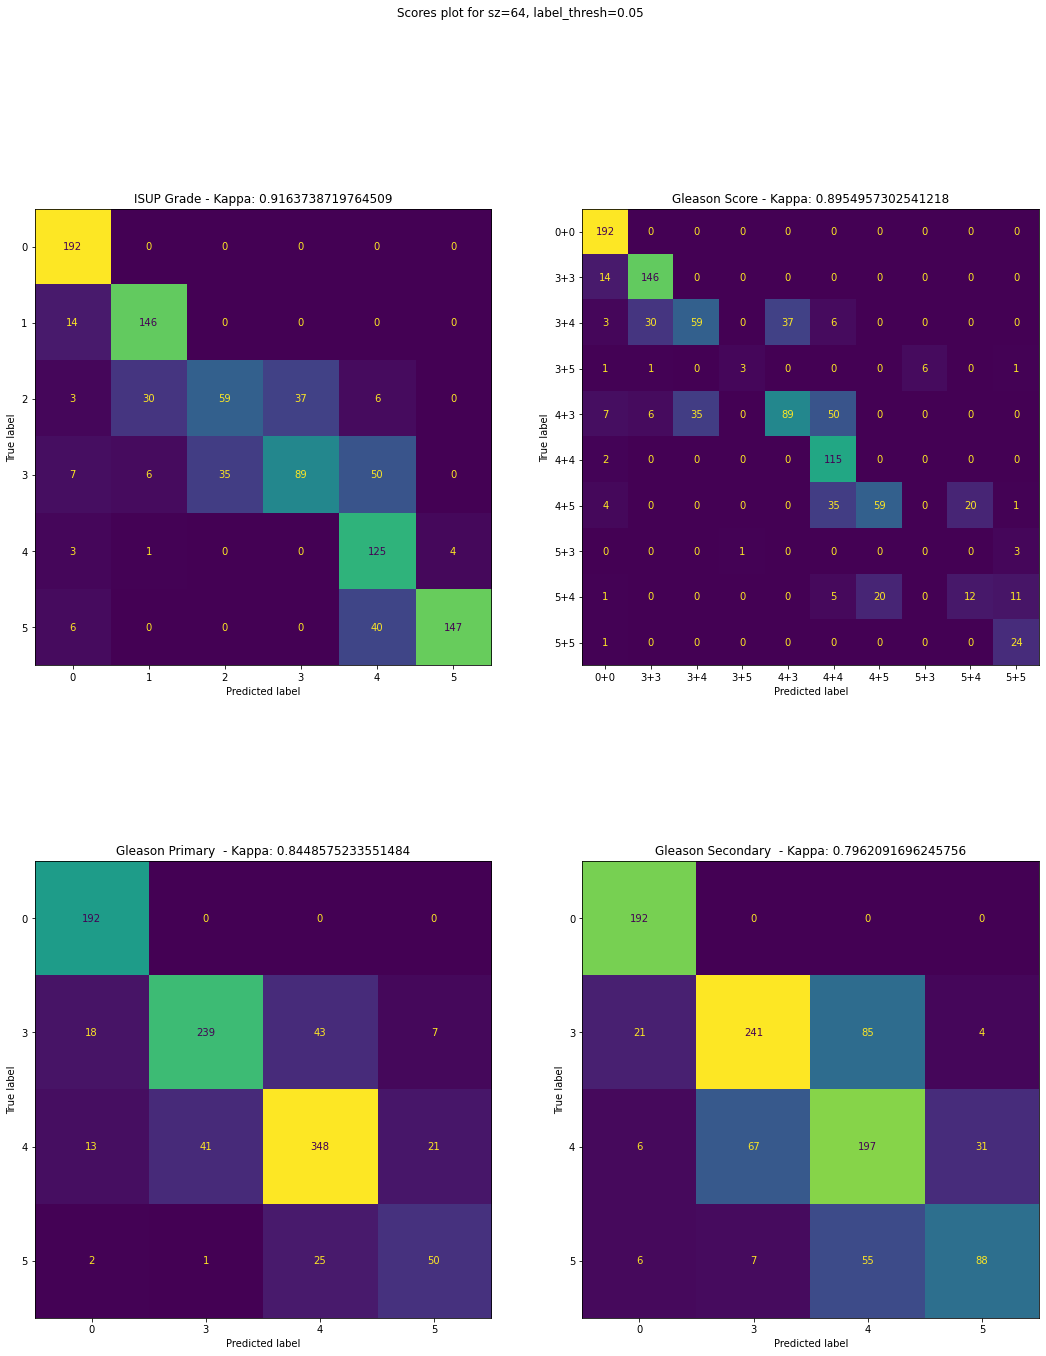

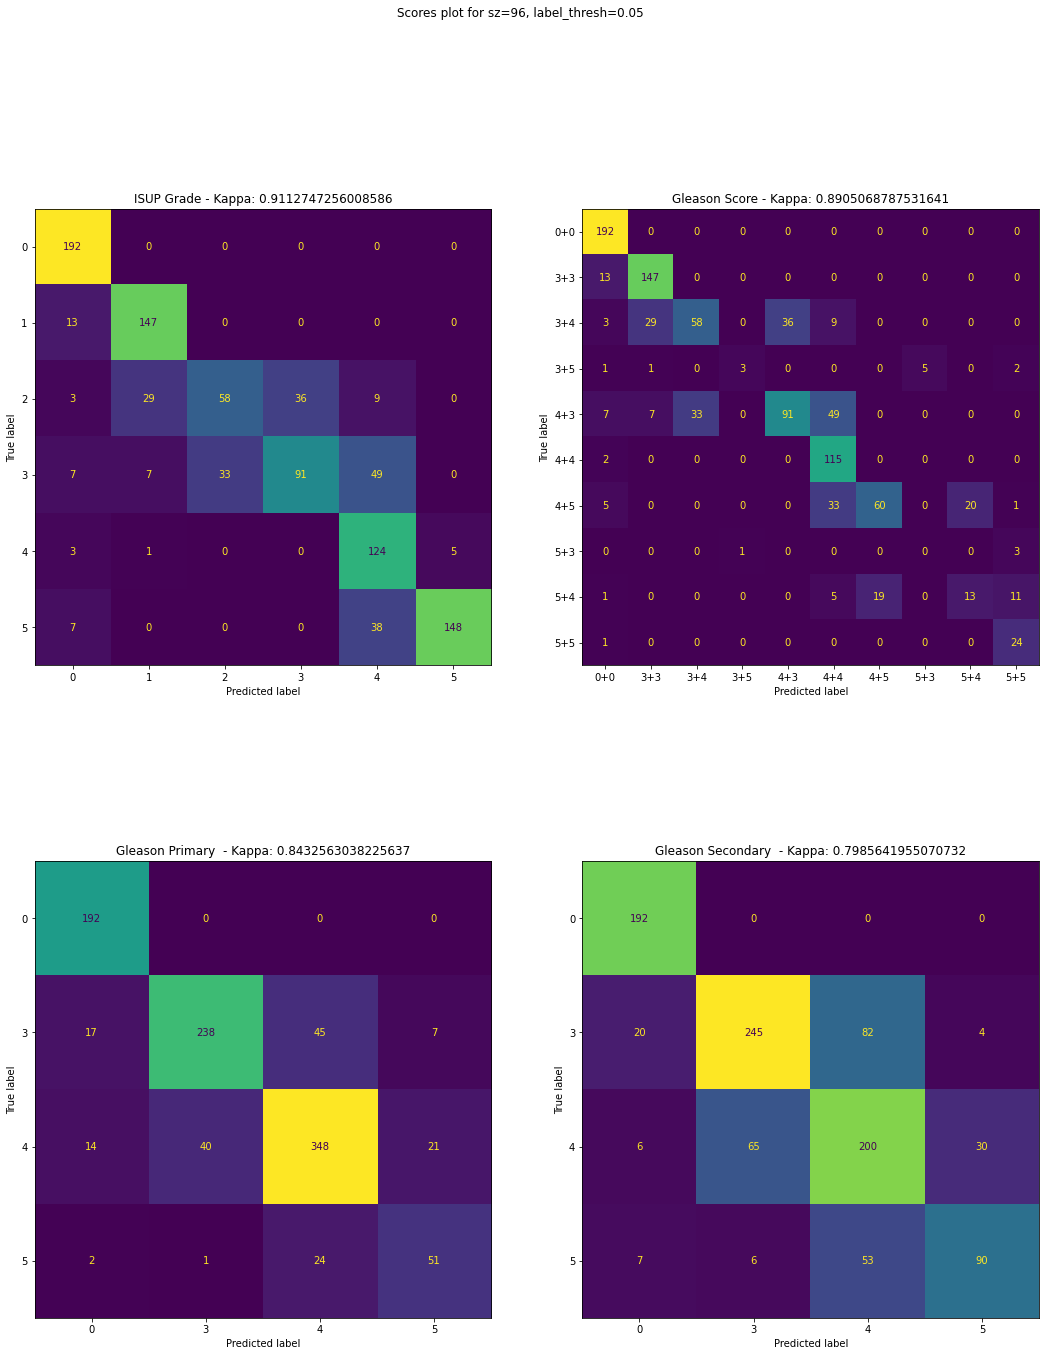

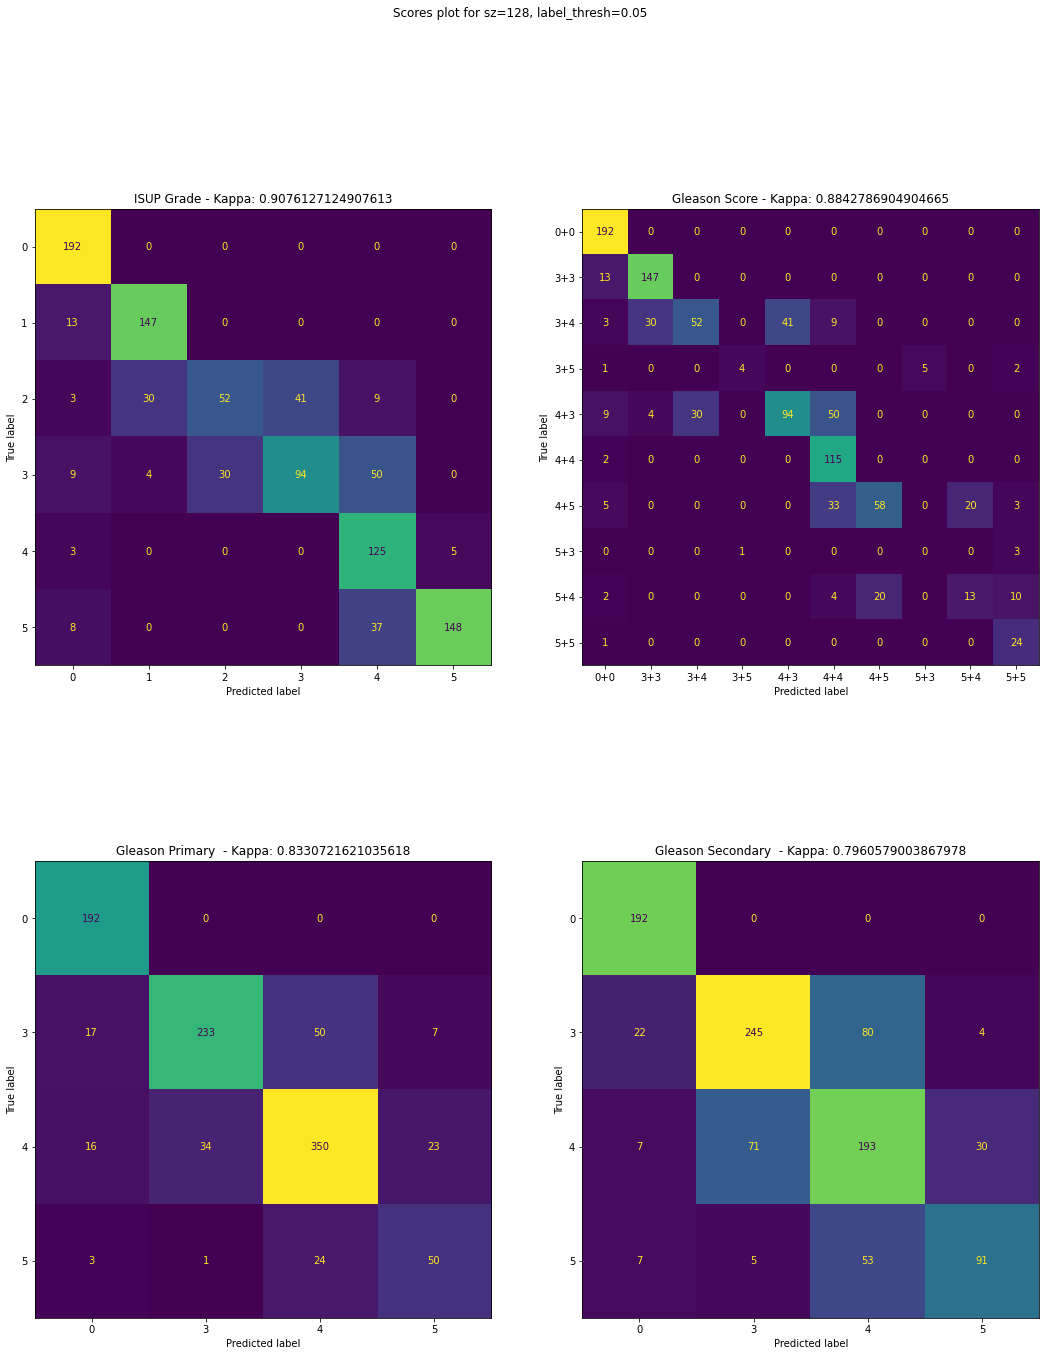

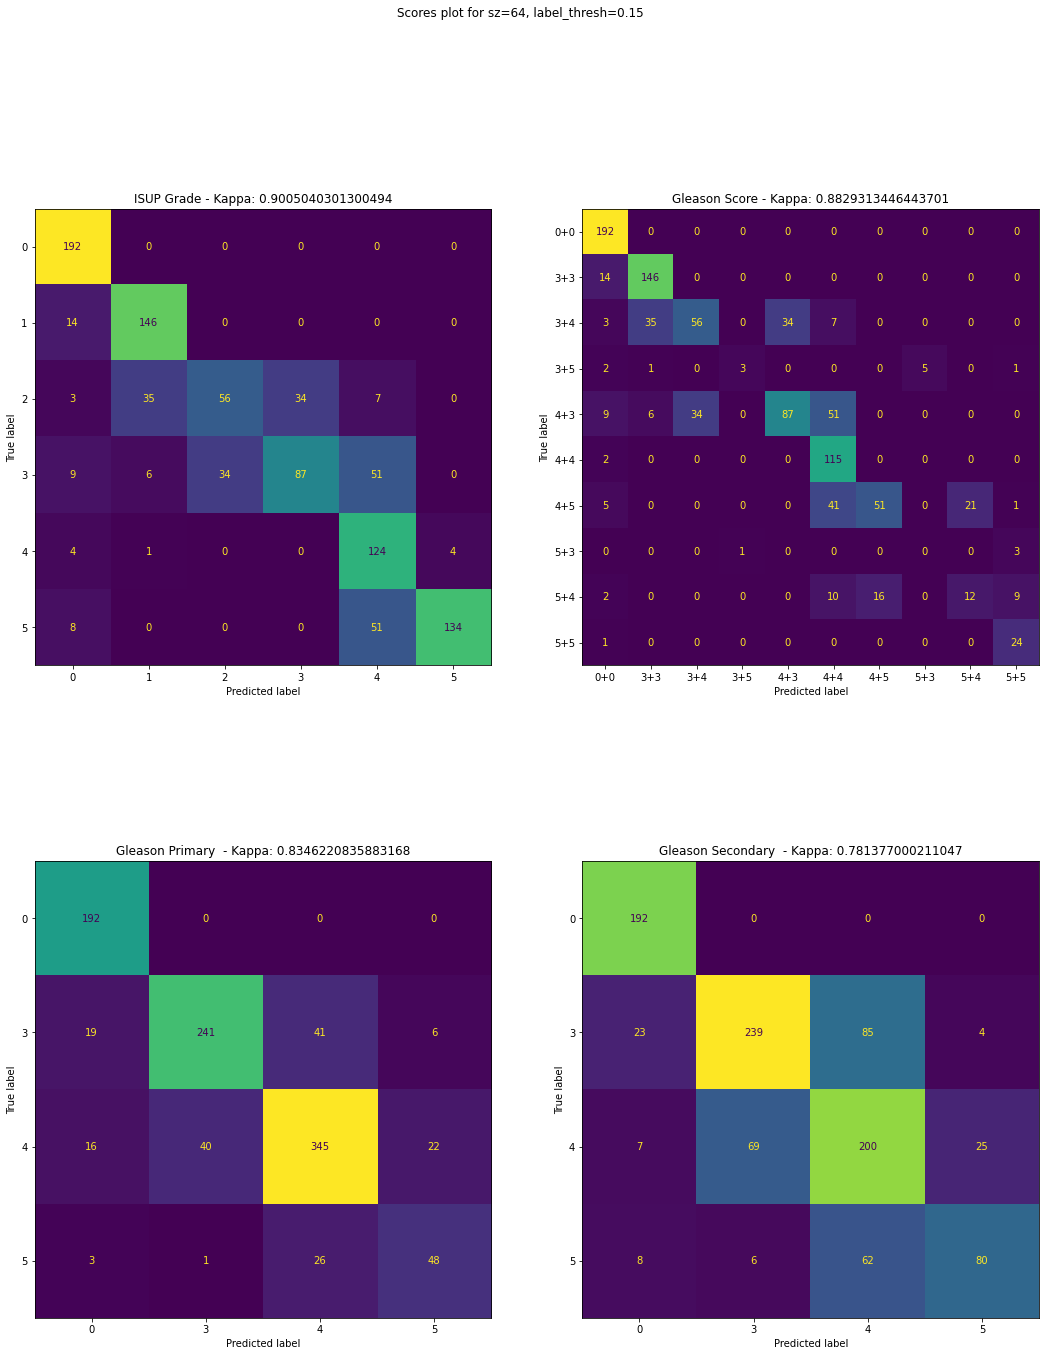

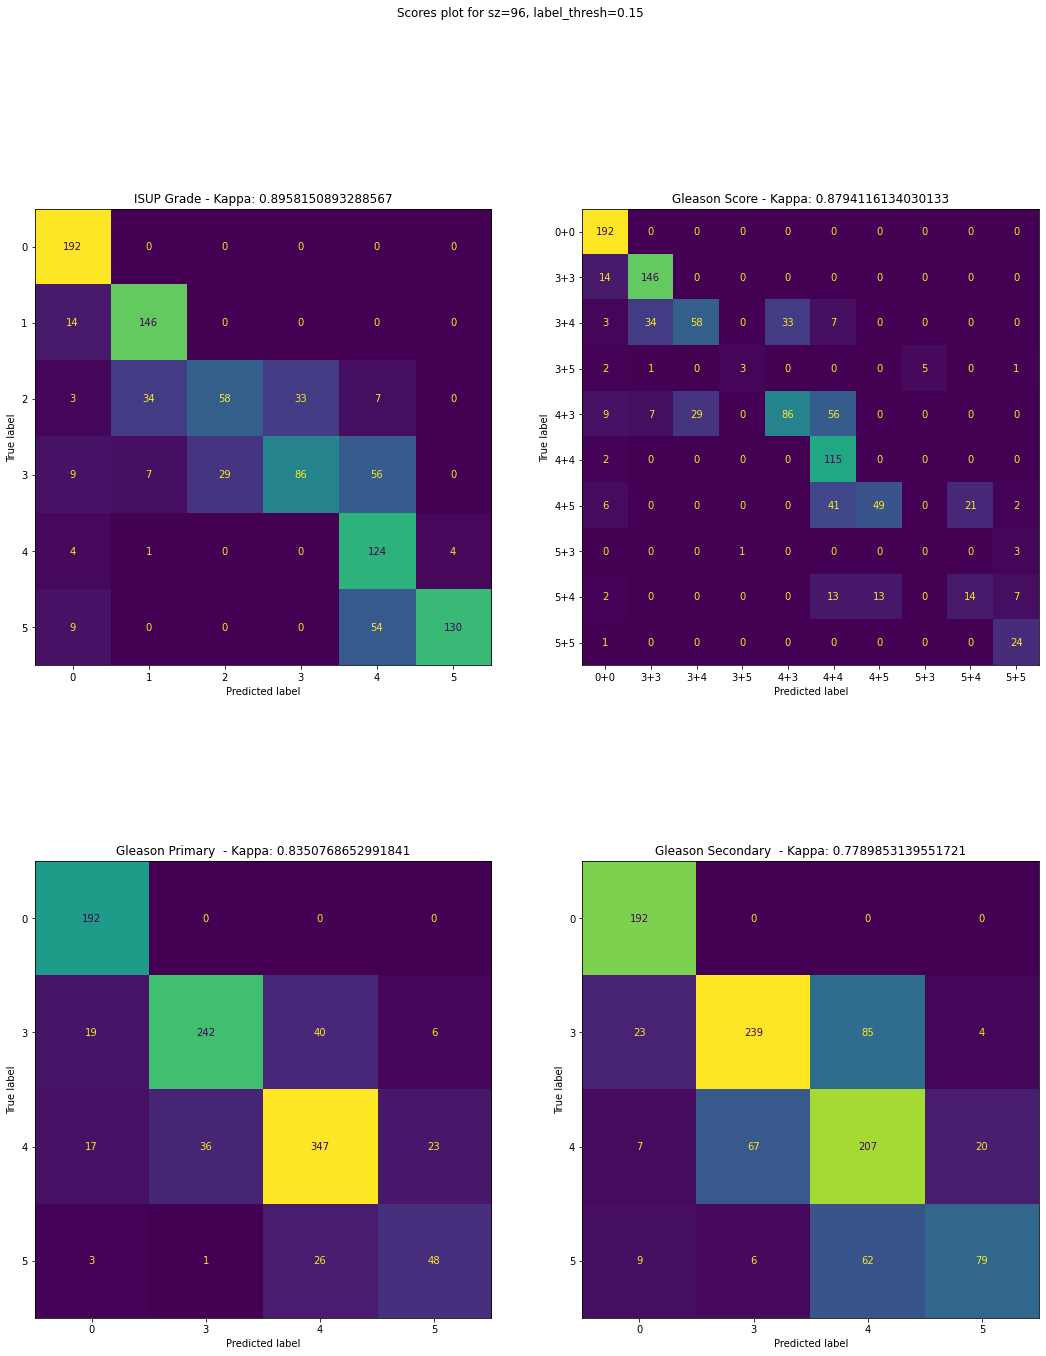

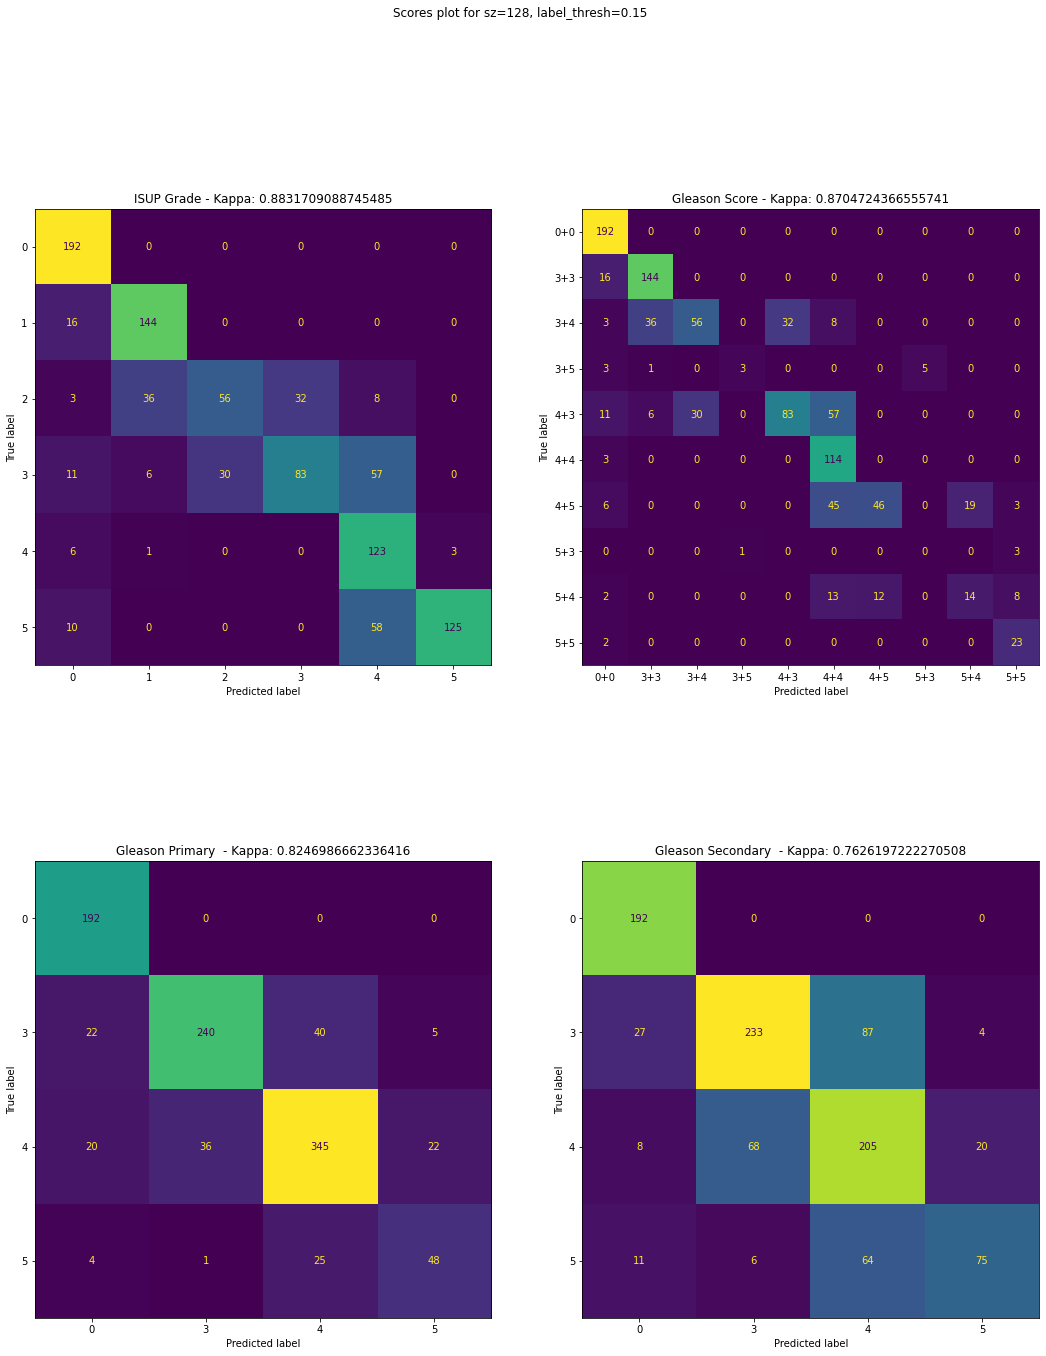

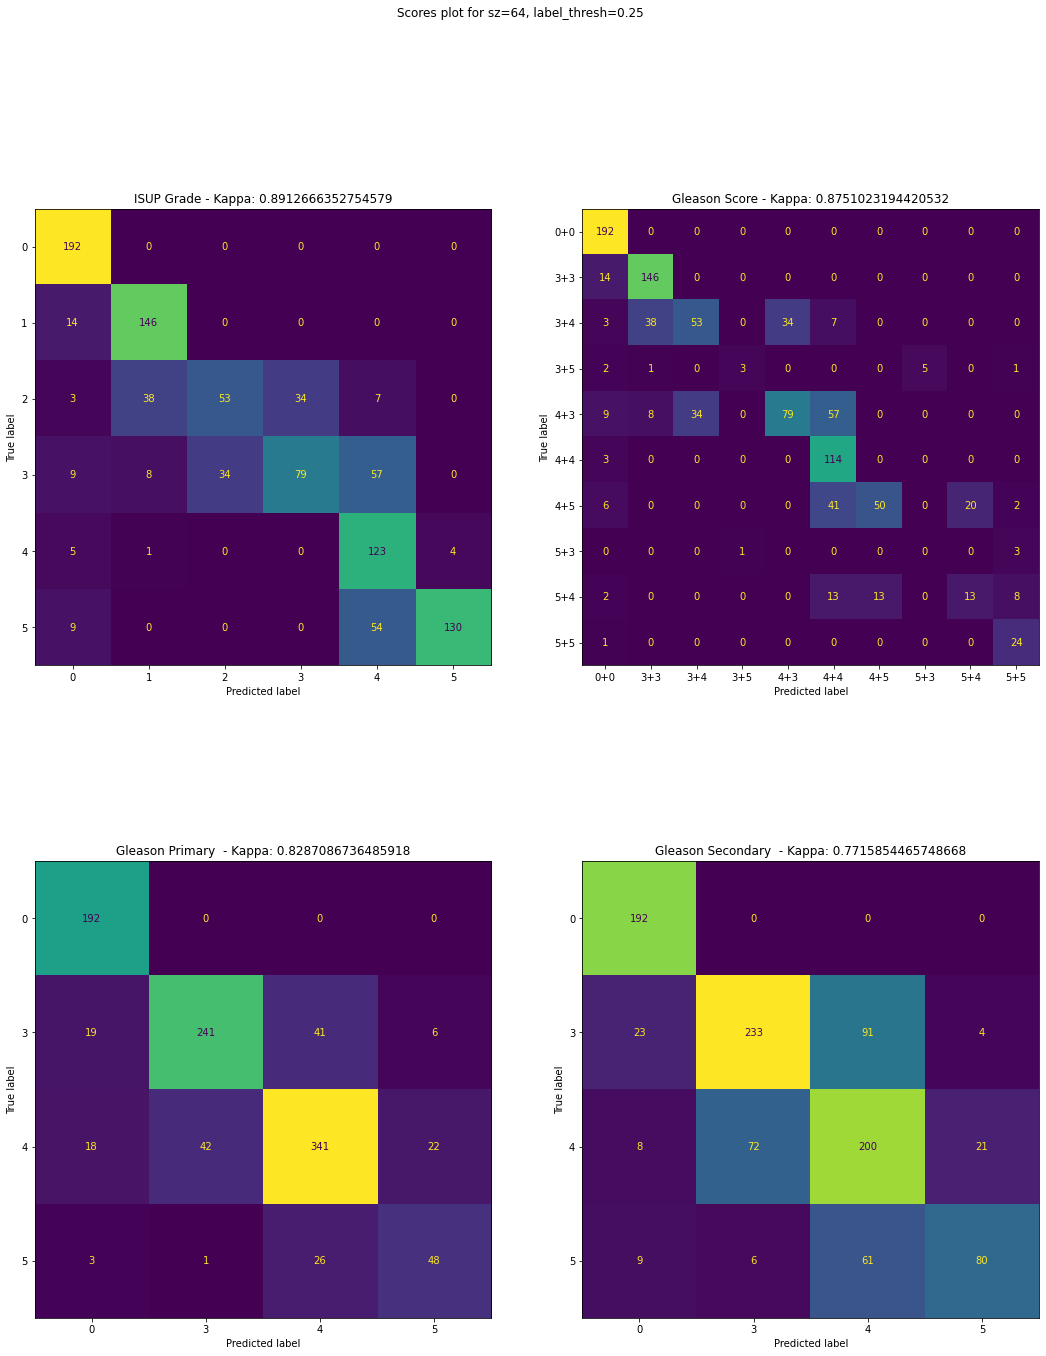

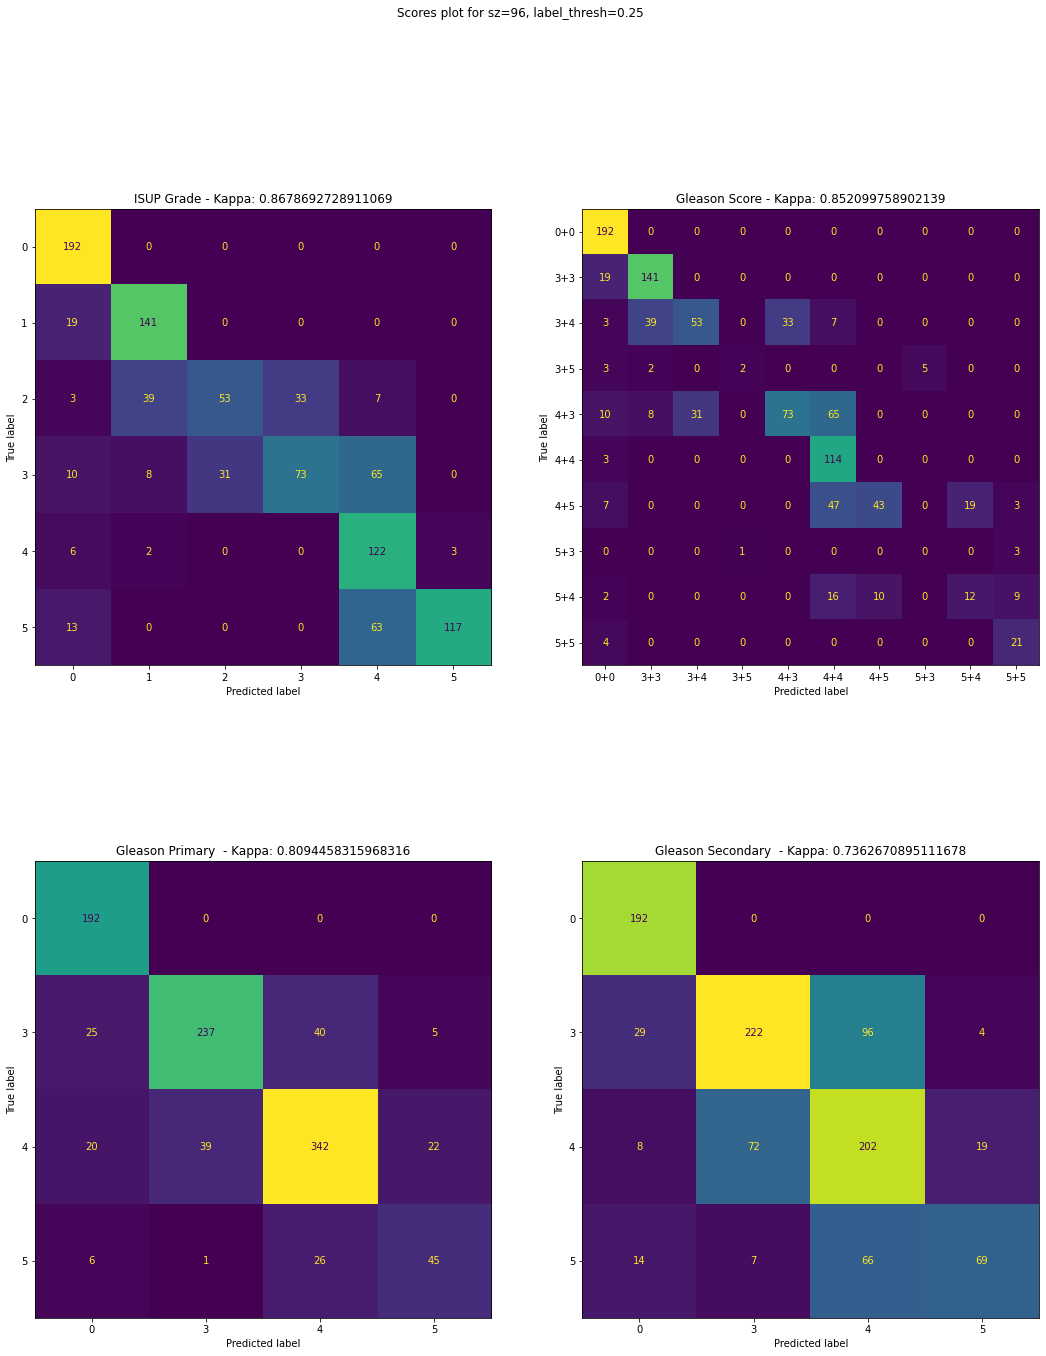

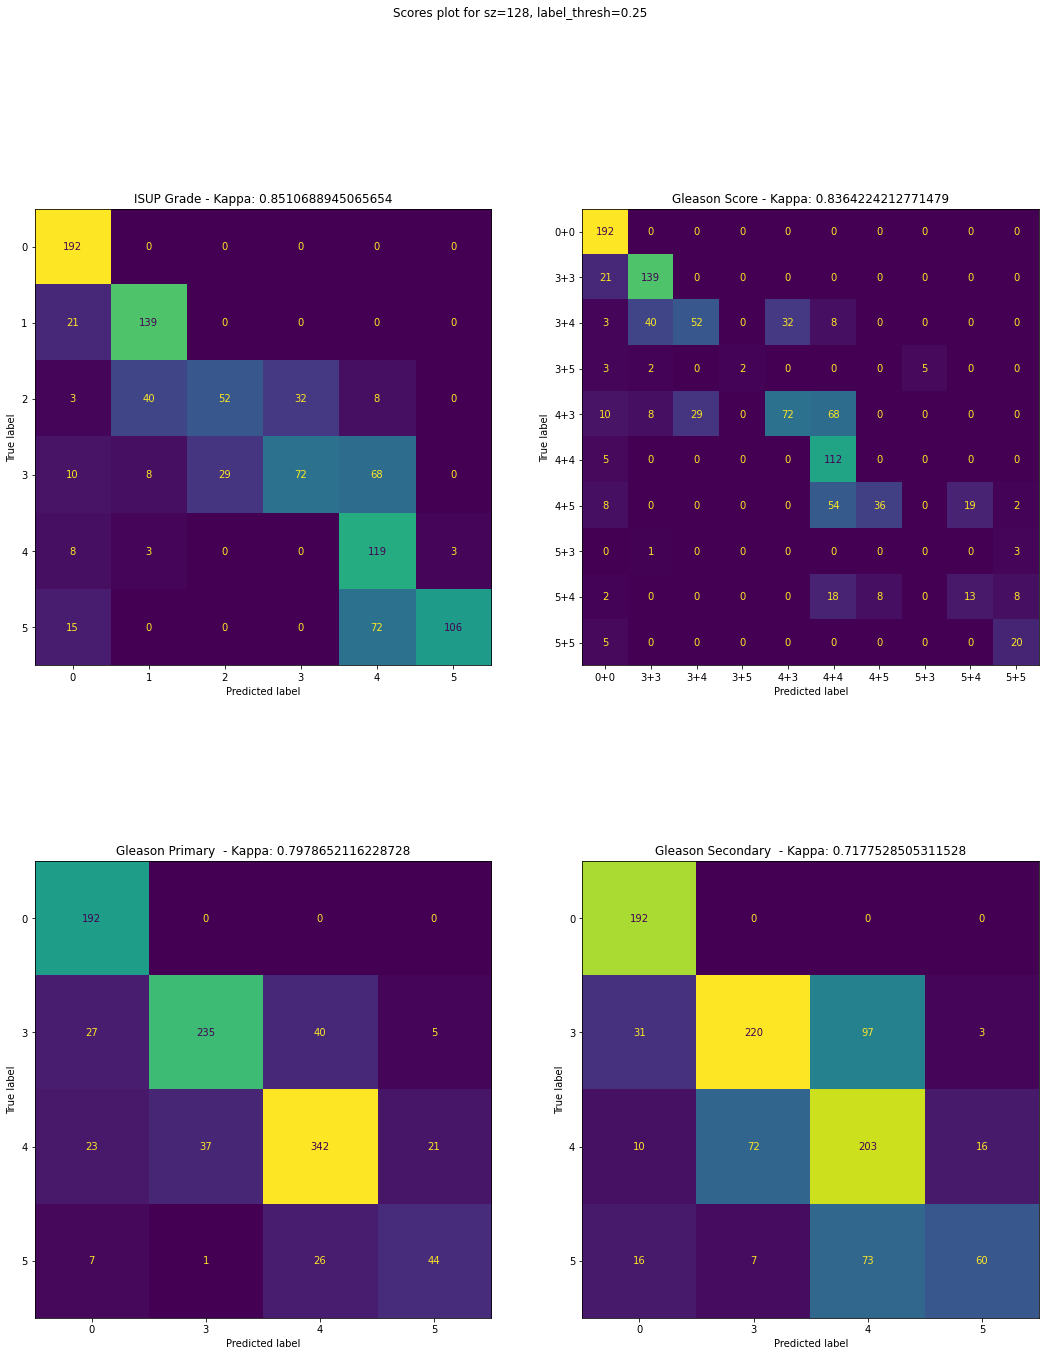

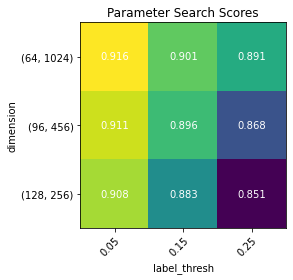

In [20]:
dimension = [(64, 1024), (96, 456), (128, 256)]
threshold = [0.05,0.15,0.25]

scores = np.zeros((len(threshold), len(dimension)))

for l in range(3):
    for d in range(3):
        sz = dimension[d][0]
        N_max = dimension[d][1]
        label_thresh = threshold[l]

        test_ids=[]
        test_gleas=[]
        num_1s = []
        num_2s = []
        num_3s = []
        num_4s = []
        num_5s = []
        tots = []

        for ind in tqdm(rad_df.index):
            gleason, tot, cts = tile_strategy_test(image_id=ind,tile_lvl=0,prep_lvl=1,sz=sz,mask_thresh=0.95,pxl_thresh=225.0,
                                scoring_thresh=label_thresh,N_max=N_max,train_df=train_df)

            test_ids.append(ind)
            test_gleas.append(gleason)
            tots.append(tot)
            num_1s.append(cts[0])
            num_2s.append(cts[1])
            num_3s.append(cts[2])
            num_4s.append(cts[3])
            num_5s.append(cts[4])

        sub_df = pd.DataFrame({'image_id':test_ids,
                       'tiles_gleason':test_gleas,
                       '1_tiles':num_1s,
                       '2_tiles':num_2s,
                       '3_tiles':num_3s,
                       '4_tiles':num_4s,
                       '5_tiles':num_5s,
                       'Tile_total':tots})

        sub_df['predicted_isup'] = sub_df['tiles_gleason'].apply(lambda x: gleason_to_isup[x])

        sub_df = sub_df.merge(rad_df,how='left',left_on='image_id',right_index=True)
        sub_df.rename(columns={'gleason_score':'actual_gleason','isup_grade':'actual_isup'},inplace=True)
    
        act_gleason_prim = []
        act_gleason_sec = []
        pred_gleason_prim = []
        pred_gleason_sec = []
        
        for ind in sub_df.index:
            if sub_df['actual_gleason'][ind][0].isnumeric():
                act_gleason_prim.append(sub_df['actual_gleason'][ind][0])
                act_gleason_sec.append(sub_df['actual_gleason'][ind][2])
            else:
                act_gleason_prim.append('0')
                act_gleason_sec.append('0')        
            pred_gleason_prim.append(sub_df['tiles_gleason'][ind][0])
            pred_gleason_sec.append(sub_df['tiles_gleason'][ind][2])

        sub_df['act_gleason_prim'] = act_gleason_prim
        sub_df['act_gleason_sec'] = act_gleason_sec
        sub_df['pred_gleason_prim'] = pred_gleason_prim
        sub_df['pred_gleason_sec'] = pred_gleason_sec

        sub_df = sub_df[['image_id','tiles_gleason','actual_gleason','predicted_isup',
                         'actual_isup','pred_gleason_prim','act_gleason_prim',
                         'pred_gleason_sec','act_gleason_sec', '1_tiles','2_tiles',
                         '3_tiles','4_tiles','5_tiles','Tile_total','data_provider']]

        sub_df.replace(['negative','0+0','0+1','0+2','1+0','1+1','1+2','2+0','2+1','2+2'], '0+0', inplace = True)
        kappascore_plot(sub_df,f'Scores plot for sz={sz}, label_thresh={label_thresh}',
                        f'kplot_d{sz}_l{int(label_thresh*100)}.png')
        sub_df.to_csv(f'data_d{sz}_l{int(label_thresh*100)}.csv')
        p = sub_df['predicted_isup']
        t = sub_df['actual_isup']
        isup_kappa = cohen_kappa_score(t,p,weights='quadratic')
        print('Dimesnion: ', sz, ', Label threshold: ',label_thresh, ', Kappa Score: ', isup_kappa)
        scores[d,l] = isup_kappa
        
scores_map(dimension,'dimension', threshold,'label_thresh', scores,
           'Dim_Labelthresh_map.png')


With publicly visible scores of over 0.92 on the competition leaderboard we can now safely conclude that this approach to the problem will not be competitive as it falls short even under the most idealized scenarios (perfect classification of tiles and perfect generalization of the model from the Radboud data that it was trained on to the Karolinska data). Since this performance shortfall is due to inaccuracies in the masks, we will have to aim to classify samples without the masks. The next option that we will try is the end-to-end approach, going directly from an image to its stated ISUP score in the provided data table.